# New env

# load from prerunning data　bach-train

In [1]:
import sys,os
import numpy as np
from itertools import count
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Envの作成

In [15]:
class G4env():
    def __init__(self, batch_size = 64):

        self.batch_size = batch_size
        self.angle = np.zeros(self.batch_size)
        self.r = torch.empty((1,30,31,31),dtype=torch.float32)
        self.done = torch.zeros(self.batch_size).view(self.batch_size,1)

        self.ang_range = 85
        self.event_num = 1000
        self.angle_step = 5.0
        
        # Make evaluate array  
        self.ev_array = torch.zeros((30,31,31))
        self.ev_array[15:20, 0:5, 0:5] = 1
        
        # Make dict of dose distribution and angle 
        self.dose = dict()
        angles = [-90 + 5 * a for a in range(36)]
        for angle in angles:
            d = pd.read_csv("data/dose_t=" + str(angle) + ".csv")['dose']
            d = np.array(d).reshape(1,30,31,31) / self.event_num
            # d = torch.tensor(d)
            self.dose[angle] = d

    def reset(self):
        self.r = torch.zeros((1,30,31,31),dtype=torch.float32)
        self.r_new = 0
        self.angle = np.zeros(self.batch_size)
        self.done = torch.zeros(self.batch_size).view(self.batch_size,1).to(device)

        states = np.array([self.dose[a] for a in self.angle])
        states = torch.tensor(states, dtype=torch.float32).to(device)
        
        return states
    
    def GetReward(self, angle):#報酬の計算用関数
        self.r = self.ev_array * self.dose[angle] #報酬を記憶
        reward = self.r.to(torch.float32).sum().sum().view(-1)
        
        return reward
    
    def step(self, action):

        rewards = torch.empty(0,dtype=torch.float32)
        
        for b in range(self.batch_size):    
            self.angle[b] += self.angle_step * (action[b] - 1)
            
            if (np.abs(self.angle[b]) >= self.ang_range):
                self.done[b] = 1
            
            reward = self.GetReward(self.angle[b])      #Reward を計算
            rewards = torch.cat([rewards, reward],dim=0) #配列を組み合わせる(append, push_back) 
            
        rewards = rewards.view(self.batch_size, 1).to(device)
        
        states = np.array([self.dose[a] for a in self.angle])
        states = torch.from_numpy(states).float().to(device)
        return states, rewards, self.done
    


### check env

In [5]:
e = G4env()
states = e.reset()
for _ in range(2):
    a = np.random.randint(0,2,e.batch_size)
    next_states = states
    states, rewards, dones, = e.step(a)
print(states.shape, rewards.shape, dones.shape)

torch.Size([64, 1, 30, 31, 31]) torch.Size([64, 1]) torch.Size([64, 1])


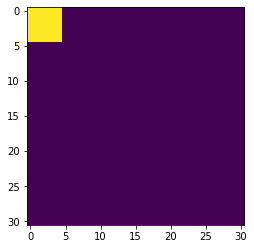

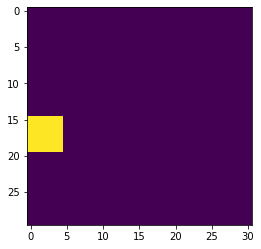

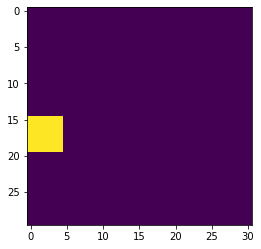

In [6]:
plt.imshow(G4env().ev_array.sum(0))
plt.show()
plt.imshow(G4env().ev_array.sum(1))
plt.show()
plt.imshow(G4env().ev_array.sum(2))
plt.show()

# Let's train

In [7]:
class NetWork(nn.Module):
    def __init__(self, nch_g=32):
        super(NetWork, self).__init__()

        self.batch_size = 32
        
        self.conv1 = nn.Conv3d(1        , nch_g    , 2)
        self.conv2 = nn.Conv3d(nch_g    , nch_g * 2, 2)
        self.conv3 = nn.Conv3d(nch_g * 2, nch_g * 4, 2)

        self.relu  = nn.ReLU()
        self.flat  = nn.Flatten()

        self.policy= nn.Linear(128 * 27 * 28 * 28, 3)
        self.value = nn.Linear(128 * 27 * 28 * 28, 1)
        self.sfmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #----------------
        x = self.conv1(x)
        x = self.relu(x)
        #----------------
        x = self.conv2(x)
        x = self.relu(x)
        #----------------
        x = self.conv3(x)
        x = self.relu(x)
        #----------------
        x = self.flat(x)
        #----------------
        probs = self.policy(x)
        probs = self.sfmax(probs)
        
        value  = self.value(x)
        
        return probs, value
        

In [8]:
class BatchNormNetWork(nn.Module):
    def __init__(self, nch_g=32):
        super(BatchNormNetWork, self).__init__()

        self.batch_size = 32
        
        self.conv1 = nn.Conv3d(1        , nch_g    , 3, padding=1)
        self.bn1 = nn.BatchNorm3d(nch_g)
        self.conv2 = nn.Conv3d(nch_g    , nch_g * 2, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(nch_g * 2)
        self.conv3 = nn.Conv3d(nch_g * 2, nch_g * 4, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(nch_g * 4)

        self.relu  = nn.LeakyReLU(0.2, inplace=True)
        self.pool = nn.MaxPool3d(2)

        self.flat  = nn.Flatten()

        self.policy= nn.Linear(nch_g * 4 * 9 * 14 * 14, 3)
        self.value = nn.Linear(nch_g * 4 * 9 * 14 * 14, 1)
        self.sfmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #----------------
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.flat(x)
        #----------------
        probs = self.policy(x)
        probs = self.sfmax(probs)
        
        value  = self.value(x)
        
        return probs, value


### Check get action

In [9]:
net = NetWork().to(device)
probs, _ = net(states)

batch_size = states.size(0)
actions = torch.multinomial(probs, 1)

selected_probs = torch.gather(probs, 1, actions)

print(actions.shape, selected_probs.shape)
print(rewards.shape)

torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])


### Check update

In [10]:
gamma = 0.01
lr_pi = 0.0002
lr_v = 0.0005
done = 0

optimizer_pi = optim.Adam(net.parameters(), lr=lr_pi)
optimizer_v = optim.Adam(net.parameters(), lr=lr_v)

# ========== (1) Update V network ============
_, v_next_states = net(next_states)
print(rewards.shape, v_next_states.shape)
print((gamma * v_next_states * (1-done)).shape)
with torch.no_grad():
    targets = rewards + gamma * v_next_states * (1 - done)
_, v_states = net(states)

print(targets.shape)
loss_v = F.mse_loss(v_states, targets)

# ========== (2) Update pi network ===========
with torch.no_grad():
    deltas = targets - v_states

loss_pi = torch.mean(-torch.log(selected_probs) * deltas)

# ========== (3) Calculate loss ===============
loss = loss_pi + loss_v

optimizer_v.zero_grad()
optimizer_pi.zero_grad()

loss.mean().backward()

optimizer_v.step()
optimizer_pi.step()

torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


In [11]:
class AgentSingleNet:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0000002
        self.lr_v = 0.0000005
        self.action_size = 3

        self.net = NetWork().to(device)
        
        self.optimizer_pi = optim.Adam(self.net.parameters(), lr=self.lr_pi)
        self.optimizer_v = optim.Adam(self.net.parameters(), lr=self.lr_v)
        
    def get_action(self, state):
        probs, _ = self.net(state)
        
        batch_size = state.size(0)
        actions = torch.multinomial(probs, 1)
        
        selected_probs = torch.gather(probs, 1, actions)
        return actions, selected_probs
        
    def update(self, states, actions_probs, rewards, next_states, dones):
        # ========== (1) Update V network ============
        _, v_next_states = self.net(next_states)
        with torch.no_grad():
            targets = rewards + self.gamma * v_next_states * (1 - dones)
        _, v_states = self.net(states)
        loss_v = F.mse_loss(v_states, targets)
        
        # ========== (2) Update pi network ===========
        with torch.no_grad():
            deltas = targets - v_states

        loss_pi = torch.mean(-torch.log(actions_probs) * deltas)
        
        # ========== (3) Calculate loss ===============
        loss = loss_pi + loss_v
        
        self.optimizer_v.zero_grad()
        self.optimizer_pi.zero_grad()

        loss.backward(retain_graph=True)  

        self.optimizer_v.step()
        self.optimizer_pi.step()


### agent test

In [12]:
import collections
import time

episodes   = 100
batch_size = 32

env = G4env(batch_size)
agent = AgentSingleNet()

reward_lis = []
angles  = []
begin = time.time()

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    count = 0
    print(episode)
    while 1:
        action, prob = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward.sum()
        count += 1

        agent.update(state, prob, reward, next_state, done)
        state = next_state
#         print("episode: ",episode,"step: ", count, "probs: ", prob, "actions: ", action, "angle: ", env.angle)
#         print("reward: ",reward)
        angles.append(env.angle[0])
        
        if count > 100:
            break
        if done.sum() > 0:
            break
    
    reward_lis.append(total_reward.item() / batch_size)
        
    if episode % 10 == 0:
        torch.save(agent, "model03/actor-critic" + str(episode))
end = time.time()
print("elapsed time is ", (end - begin) / 60, "min")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
elapsed time is  28.416605166594188 min


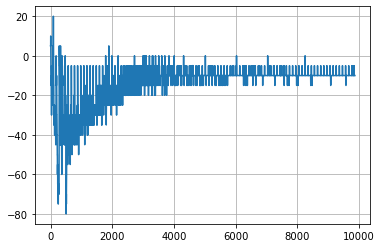

In [13]:
plt.plot(angles)
plt.grid()

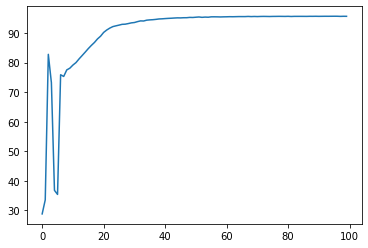

In [14]:
plt.plot(reward_lis)

batch_size 32, 1660 s

batch_size 64, 